In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from classifier import *
import features as fe 
import utils as ut

In [105]:
X_train_face_img, X_train_nonface_img, X_test_img, y_train_face, y_train_nonface, y_test = ut.get_test_train_data()

### Testing AdaBoost

In [106]:
X_train_img = np.concatenate((X_train_face_img, X_train_nonface_img))
y_train = np.concatenate((y_train_face, y_train_nonface))
X_train_ada, y_train_ada = ut.random_subset(X_train_img, y_train, 100)
X_test_ada, y_test_ada = ut.random_subset(X_test_img, y_test, 100)

In [107]:
rect = fe.get_rectanges(19, 19)
no_rect = fe.get_no_rectangles(19, 19)
X_train_ada_fe = fe.feature_extraction_images(X_train_ada, rect, no_rect)
X_test_ada_fe = fe.feature_extraction_images(X_test_ada, rect, no_rect)

In [108]:
a = AdaBoostClassifier()
a.fit(X_train_ada_fe, y_train_ada, 2)

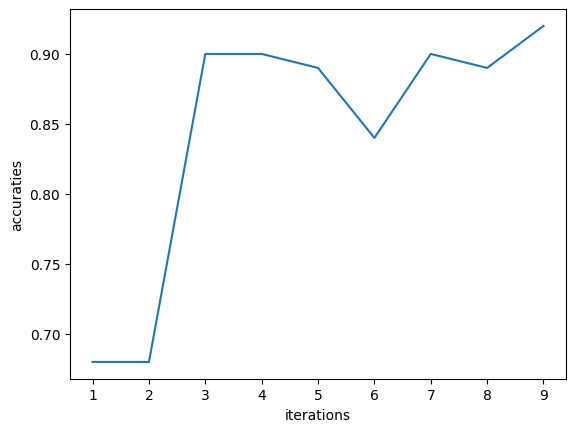

In [109]:
iters = list(range(1, 10))
accuracies = []
a = AdaBoostClassifier()
for iter in iters:
    a.fit(X_train_ada_fe, y_train_ada, iter)
    accuracy = a.score(X_test_ada_fe, y_test_ada)
    accuracies.append(accuracy)

plt.xlabel("iterations")
plt.ylabel("accuraties")
plt.plot(iters, accuracies)
plt.show()

In [110]:
print(a.threshold*0.98)
print(a.false_positive_rate(X_test_ada_fe, y_test_ada))
print(a.detection_rate(X_test_ada_fe, y_test_ada))

11.729429299332208
0.07216494845360824
0.02


In [111]:
# split the training data into 10 folds
X_train_folds = np.array_split(X_train_ada_fe, 10)
y_train_folds = np.array_split(y_train_ada, 10)


In [112]:
f = 0.9
d = 0.9
F_target = 0.001
Threshold_retention = 0.99
Strong_Classifiers = []

def get_avg_fpr_dtr(a,X_train_folds, y_train_folds,number):
    false_positive_rate = 0
    detection_rate = 0
    for i in range(number):
        index = np.random.choice(10,1, replace=False)
        X_train = X_train_folds[index[0]]
        y_train = y_train_folds[index[0]]
        false_positive_rate += a.false_positive_rate(X_train, y_train)
        detection_rate += a.detection_rate(X_train, y_train)
    return false_positive_rate/3, detection_rate/3


def Train_Cascade(f,d,F_target,Threshold_retention):    
    F = [0.6]
    D = [0.6]
    F_new = F[-1]
    Strong_Classifiers = []
    while F_new > F_target:
        a = AdaBoostClassifier()
        F_new = F[-1]
        no_of_features = 0
        while F_new > f*F[-1]:
            no_of_features += 1
            a.fit(X_train_ada_fe, y_train_ada, no_of_features)         
            fpr, dtr = get_avg_fpr_dtr(a,X_train_folds, y_train_folds,3)
            F_new = fpr
            D_new = dtr
            # decrease the threshold for the ith strong classifier in the cascade
            print("passed the first while loop")
            while(True):            
                a.set_threshold(a.threshold*Threshold_retention)
                fpr, dtr = get_avg_fpr_dtr(a,X_train_folds, y_train_folds,3)
                F_new = fpr
                D_new = dtr
                print("in the second while loop and the threshold is", a.threshold," ", F_new, " ", D_new," ",d*D[-1]," ",no_of_features)
                if D_new > d*D[-1]:          
                    break      
        print(F_new)          
        F.append(F_new)
        D.append(D_new)
        Strong_Classifiers.append(a)     
    return Strong_Classifiers

Strong_Classifiers = np.array(Train_Cascade(f,d,F_target,Threshold_retention))
print("the length of the strong classifiers is", len(Strong_Classifiers))




passed the first while loop
in the second while loop and the threshold is 1.5375097637078137   0.0   0.4000000000000001   0.54   1
in the second while loop and the threshold is 1.5221346660707356   0.25132275132275134   0.26666666666666666   0.54   1
in the second while loop and the threshold is 1.5069133194100282   0.16666666666666666   0.3   0.54   1
in the second while loop and the threshold is 1.491844186215928   0.037037037037037035   0.16666666666666666   0.54   1
in the second while loop and the threshold is 1.4769257443537687   0.037037037037037035   0.19999999999999998   0.54   1
in the second while loop and the threshold is 1.462156486910231   0.0   0.3666666666666667   0.54   1
in the second while loop and the threshold is 1.4475349220411287   0.047619047619047616   0.43333333333333335   0.54   1
in the second while loop and the threshold is 1.4330595728207174   0.07407407407407407   0.16666666666666666   0.54   1
in the second while loop and the threshold is 1.4187289770925

In [120]:
def Cascade_Classifier(X_test, Strong_Classifiers):
    y_pred = np.zeros(len(X_test))
    for i in range(len(Strong_Classifiers)):
        y_pred = Strong_Classifiers[i].predict(X_test)
        X_test = X_test[y_pred == 1]
        if len(X_test) == 0:
            break
    return y_pred

y_pred = Cascade_Classifier(X_test_ada_fe, Strong_Classifiers)
print("the accuracy of the cascade classifier is", np.sum(y_pred == y_test_ada)/len(y_test_ada))



(100,)
the accuracy of the cascade classifier is 0.68
